In [1]:
import pandas as pd
import h5py
import hdf5plugin
from datetime import datetime

# Path to UK-DALE HDF5 file
file_path = '/users/kjain/Downloads/ukdale.h5'

# Define a manual mapping of meters to appliances (Update if needed)
# Define a manual mapping of meters to appliances
# Define a manual mapping of meters to appliances
meter_mapping = {
    'meter1': 'Main Power',
    'meter2': 'Kettle',
    'meter3': 'Electric Heater',
    'meter4': 'Laptop',
    'meter5': 'Projector'
}

# Open the HDF5 file
with h5py.File(file_path, 'r') as hdf:
    print("Keys:", list(hdf.keys())) # Check available buildings

    # Navigate to House 1's electricity data
    house_path = 'building3/elec'
    house_data = hdf[house_path]

    # List to store DataFrames for each meter
    meter_dfs = []

    # Process meters (select relevant meters based on mapping)
    for meter_id in meter_mapping.keys():
        meter_path = f"{house_path}/{meter_id}"

        if "table" in house_data[meter_id]:
            print(f"Processing {meter_id} ({meter_mapping[meter_id]})...")
            table_data = house_data[meter_id]['table']
            
            # Read data in chunks (optimized for memory usage)
            timestamps = []
            power_values = []

            for entry in table_data[:500000]: # Read only 500,000 entries at a time
                timestamp, power = entry
                timestamps.append(datetime.utcfromtimestamp(timestamp / 1e9)) # Convert nanoseconds
                power_values.append(power[0]) # Extract first power value

            # Create DataFrame
            df_meter = pd.DataFrame({'timestamp': timestamps, meter_mapping[meter_id]: power_values})

            # Append to list (we will merge later)
            meter_dfs.append(df_meter)

    # Merge all meter DataFrames on timestamp
    df = meter_dfs[0]
    for meter_df in meter_dfs[1:]:
        df = df.merge(meter_df, on='timestamp', how='outer') # Outer join to include all timestamps

    # Convert timestamp to DateTimeIndex
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)

    # ✅ Filter for January 2013
    df_month = df.loc['2013-02-17':'2013-03-17']

    # Save to CSV
    df_month.to_csv('house3_january2013_some_appliances.csv')

print("✅ Data saved to house3_january2013_some_appliances.csv")

Keys: ['building1', 'building2', 'building3', 'building4', 'building5']
Processing meter1 (Main Power)...
Processing meter2 (Kettle)...
Processing meter3 (Electric Heater)...
Processing meter4 (Laptop)...
Processing meter5 (Projector)...
✅ Data saved to house3_january2013_some_appliances.csv


/var/folders/sj/1c1l30xn36dgw92bwyf1rn_w0000gp/T/ipykernel_3464/169391432.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df.resample('1H').mean()


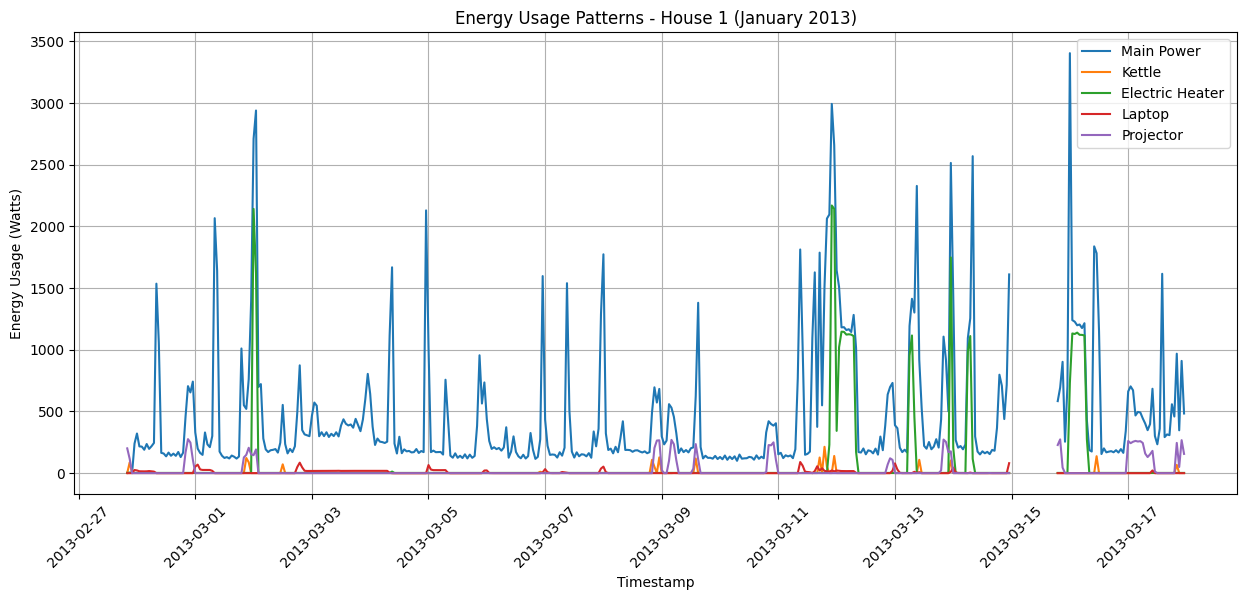

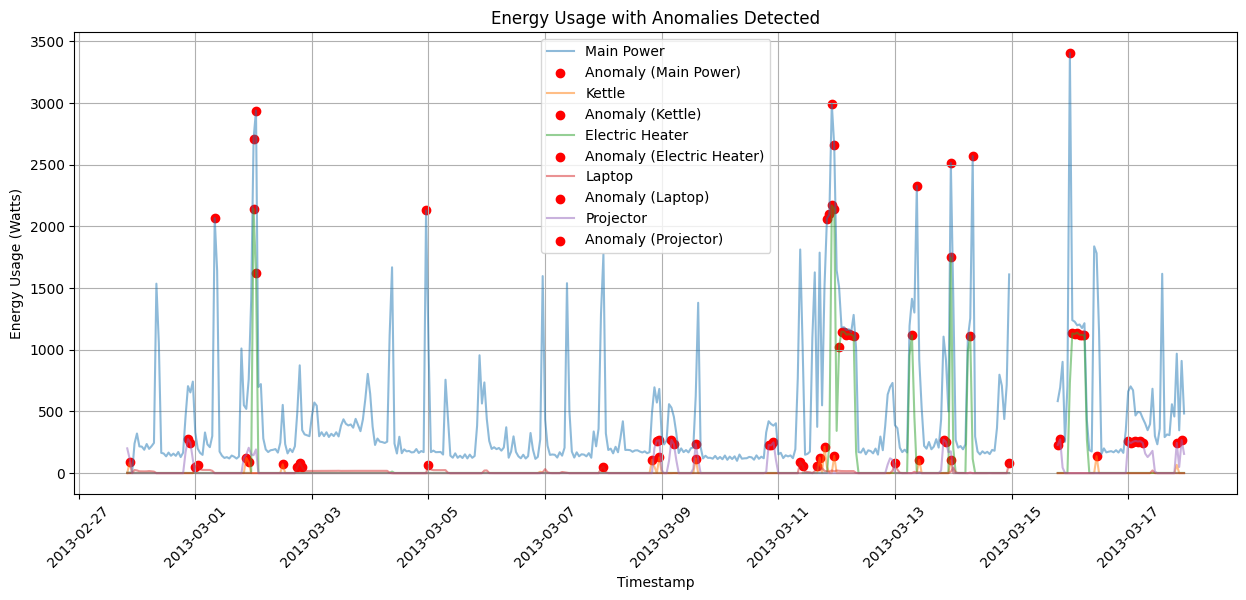


Anomalies in Main Power:
timestamp
2013-03-01 08:00:00    2067.274510
2013-03-02 00:00:00    2710.511364
2013-03-02 01:00:00    2940.268519
2013-03-04 23:00:00    2130.443503
2013-03-11 20:00:00    2064.146296
2013-03-11 21:00:00    2097.366355
2013-03-11 22:00:00    2993.837838
2013-03-11 23:00:00    2658.169550
2013-03-13 09:00:00    2328.679868
2013-03-13 23:00:00    2515.166341
2013-03-14 08:00:00    2570.023179
2013-03-16 00:00:00    3405.156425
Name: Main Power, dtype: float64

Anomalies in Kettle:
timestamp
2013-02-27 21:00:00     87.476271
2013-03-01 21:00:00    123.013582
2013-03-01 22:00:00     88.456853
2013-03-02 12:00:00     71.576271
2013-03-08 20:00:00    108.398649
2013-03-08 23:00:00    128.064081
2013-03-09 14:00:00    118.786802
2013-03-11 17:00:00    126.892617
2013-03-11 19:00:00    213.807107
2013-03-11 23:00:00    139.385000
2013-03-13 10:00:00    108.481419
2013-03-13 23:00:00    103.335008
2013-03-16 11:00:00    137.493289
Name: Kettle, dtype: float64

Anomali

In [2]:
import pandas as pd
import numpy as np
import hdf5plugin
import h5py
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/users/kjain/Project/house3_january2013_some_appliances.csv'
df = pd.read_csv(file_path, parse_dates=['timestamp'], index_col='timestamp')

# Resample data to hourly mean to reduce noise
df_resampled = df.resample('1H').mean()

# Plot Time Series Data
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column)

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage Patterns - House 1 (January 2013)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# --- Anomaly Detection ---
# Define threshold using standard deviation
threshold = 3 # Adjust this if needed
mean_usage = df_resampled.mean()
std_dev = df_resampled.std()

# Identify anomalies (values beyond mean ± threshold * std deviation)
anomalies = ((df_resampled - mean_usage).abs() > (threshold * std_dev))

# Plot Anomalies
plt.figure(figsize=(15, 6))
for column in df_resampled.columns:
    plt.plot(df_resampled.index, df_resampled[column], label=column, alpha=0.5)
    anomaly_points = df_resampled[column][anomalies[column]]
    plt.scatter(anomaly_points.index, anomaly_points, color='red', label=f'Anomaly ({column})')

plt.xlabel('Timestamp')
plt.ylabel('Energy Usage (Watts)')
plt.title('Energy Usage with Anomalies Detected')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Print anomaly timestamps
for column in df_resampled.columns:
    print(f"\nAnomalies in {column}:")
    print(df_resampled[column][anomalies[column]].dropna())